# Diabetes Dataset Classification

LOAD DATA

In [99]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)
y = diabetes_data["Diabetes_binary"]

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print(X_train.shape)

(152208, 21)


### LDA classification

In [84]:
# classification
class_means,class_cov = functions.LDA_classifier_train_cov(X_train, Y_train,2)
predicted_labels = functions.LDA_classifier_predict_cov(X_test,class_means,class_cov,2)

print("class' means :", class_means)
print("class' covariance :", class_cov)    # y a pas mieux à plot/print ??????


class' means : [[3.77068702e-01 3.83473282e-01 9.57900763e-01 2.77905038e+01
  4.29946565e-01 3.17175573e-02 7.33740458e-02 7.77969466e-01
  6.43106870e-01 8.19480916e-01 6.09236641e-02 9.50099237e-01
  8.07175573e-02 2.38610687e+00 2.98323664e+00 3.64916794e+00
  1.34725191e-01 4.34541985e-01 7.82227481e+00 5.09689313e+00
  6.18895420e+00]
 [7.53489249e-01 6.72482082e-01 9.93304413e-01 3.20051867e+01
  5.16408902e-01 9.15692192e-02 2.22981894e-01 6.30799698e-01
  5.81242927e-01 7.57638627e-01 2.31044889e-02 9.59685025e-01
  1.05997737e-01 3.29154093e+00 4.45006601e+00 7.95478121e+00
  3.72453791e-01 4.78215768e-01 9.38339306e+00 4.74269144e+00
  5.19596379e+00]]
class' covariance : [[ 2.45033827e-01  7.33173221e-02  9.47249805e-03  6.93848526e-01
   2.31212101e-02  1.24910930e-02  3.02239023e-02 -2.61875727e-02
  -9.94844701e-03 -1.16883595e-02 -5.02228955e-04  3.96166653e-03
   2.51451369e-03  1.58587258e-01  2.07364107e-01  7.03182333e-01
   4.15794730e-02  1.27428415e-02  5.1717340

In [85]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, class_cov, functions.LDA_classifier_predict_cov)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)


training_accuracy : 0.7444943761168926
test_accuracy : 0.7431212551245664


### QDA classification

In [86]:
# using QDA classifier
class_means,cov = functions.QDA_classifier_train(X_train, Y_train,2)
predicted_labels = functions.QDA_classifier_predict(X_test,class_means,cov,2)

#print("class' means :", class_mean)
#print("class' covariance :", cov)


In [87]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, cov, functions.QDA_classifier_predict)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

training_accuracy : 0.6553926206244087
test_accuracy : 0.6553729107537054


### Neural Net

In [88]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))


Accuracy: 0.8620309050772627


In [ ]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [91]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

[Epoch   1/50] LR 1.000e-03 | Train loss 14.1265  Train acc 71.32% | Val loss 14.0905  Val acc 70.35%
[Epoch   5/50] LR 1.000e-03 | Train loss 14.0470  Train acc 72.75% | Val loss 14.0769  Val acc 71.25%
[Epoch  10/50] LR 1.000e-03 | Train loss 14.0304  Train acc 73.01% | Val loss 14.0738  Val acc 72.44%
[Epoch  15/50] LR 1.000e-04 | Train loss 14.0135  Train acc 72.88% | Val loss 14.0723  Val acc 72.80%
[Epoch  20/50] LR 1.000e-04 | Train loss 14.0063  Train acc 73.19% | Val loss 14.0737  Val acc 72.92%
[Epoch  25/50] LR 1.000e-05 | Train loss 14.0163  Train acc 73.34% | Val loss 14.0738  Val acc 72.91%
[Epoch  30/50] LR 1.000e-06 | Train loss 14.0107  Train acc 73.35% | Val loss 14.0738  Val acc 72.91%
[Epoch  35/50] LR 1.000e-07 | Train loss 14.0102  Train acc 73.35% | Val loss 14.0738  Val acc 72.90%
[Epoch  40/50] LR 1.000e-08 | Train loss 14.0078  Train acc 73.35% | Val loss 14.0738  Val acc 72.90%
[Epoch  45/50] LR 1.000e-08 | Train loss 14.0069  Train acc 73.35% | Val loss 14.0

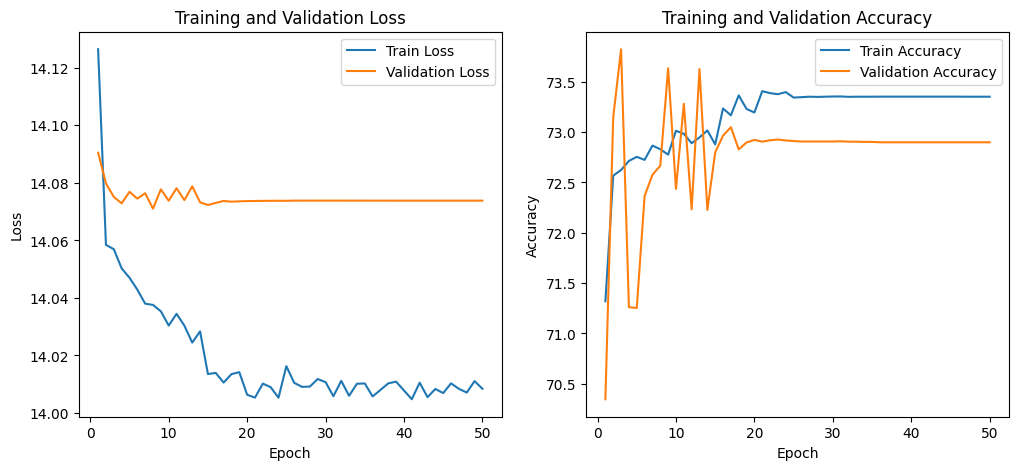

In [94]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)

0.7289892778303374

### Equilibrating the data set

In [ ]:
from sklearn.utils import resample

# The dataset being non equilibrated we'll do oversampling

# build a DataFrame from current training arrays
feature_names = diabetes_data.drop("Diabetes_binary", axis=1).columns
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['Diabetes_binary'] = Y_train

# separate majority and minority classes
counts = df_train['Diabetes_binary'].value_counts()
major_label = counts.idxmax()
minor_label = counts.idxmin()

df_major = df_train[df_train['Diabetes_binary'] == major_label]
df_minor = df_train[df_train['Diabetes_binary'] == minor_label]

# upsample minority to match majority
df_minor_upsampled = resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)

df_train_bal = pd.concat([df_major, df_minor_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# overwrite training arrays used later
X_train = df_train_bal.drop('Diabetes_binary', axis=1).to_numpy()
Y_train = df_train_bal['Diabetes_binary'].to_numpy()

print("Class distribution before:", counts.to_dict())
print("Class distribution after:", df_train_bal['Diabetes_binary'].value_counts().to_dict())

### Neural Net with Equilibrated Dataset

In [ ]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)

print(X_train.shape)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [ ]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

In [ ]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()